In [2]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from deepmeg.utils.convtools import compute_output_shape, conviter
import scipy as sp

In [6]:
x = np.arange(10)
y = x
fit = np.polyfit(x, y, 10)
y0 = sum([el*x[2]**(len(fit) - i) for i, el in enumerate(fit)])
y0, y[2]

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


(4.0, 2)

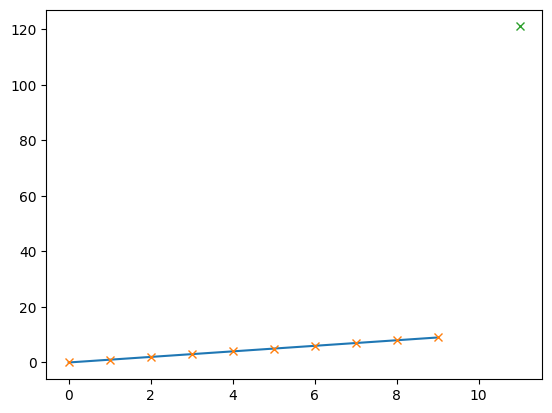

In [7]:

fit = np.polyfit(x, y, 2)
x0 = 11
y0 = sum([el*x0**(len(fit) - i) for i, el in enumerate(fit)])
plt.plot(x, y)
plt.plot(x, y, 'x')
plt.plot(x0, y0, 'x')

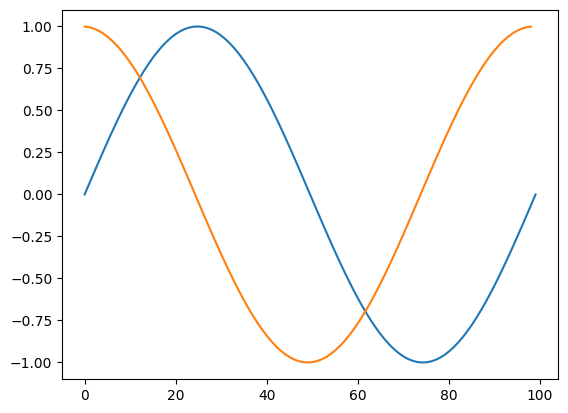

In [63]:
import torch

t = np.linspace(0, 2*np.pi, 100)
dt = t[1] - t[0]
y = np.sin(t)
y = torch.Tensor(y)

plt.plot(y)
plt.plot(y.diff()/dt)

In [114]:
y.diff().shape, y.diff(n=2).shape, y.diff(n=3).shape

(torch.Size([99]), torch.Size([98]), torch.Size([97]))

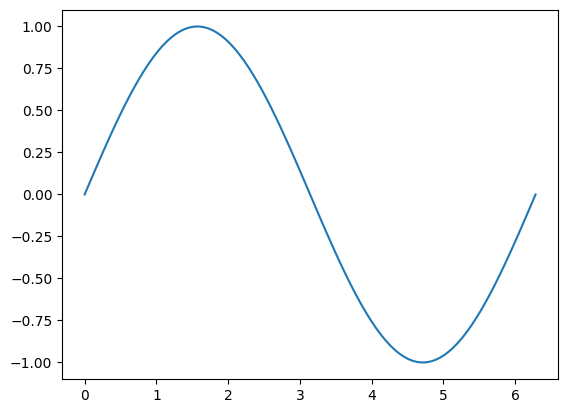

In [122]:
plt.plot(t, y)

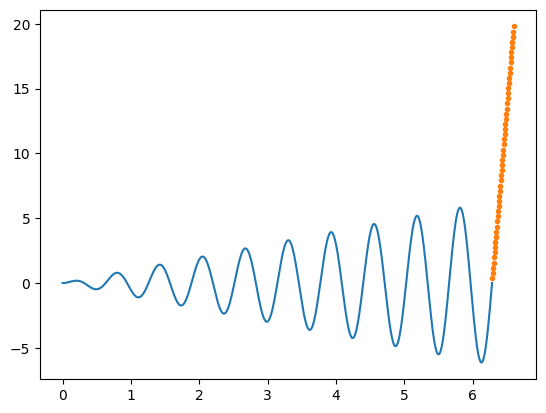

In [4]:
import math as m

def tailor_extrapolation(y, dt, order=5):
    derivatives = [y.diff(n=i)[-order:] for i in range(order + 1)]
    return sum([
        dy[-1].item()/m.factorial(n) #*dt**n
        for n, dy in enumerate(derivatives)
    ])


def recurrent_tailor_extrapolation(y, last_t, dt, order=5, n_points=1):
    if n_points > 0:
        next_y = tailor_extrapolation(y, dt, order=order)
        next_t = last_t + dt
        y = torch.cat([y, torch.Tensor([next_y])], axis=-1)
        return recurrent_tailor_extrapolation(y, next_t, dt, order=order, n_points=n_points-1)
    else:
        return y

t = np.linspace(0, 2*np.pi, 1000)
dt = t[1] - t[0]
# y = np.cos(10*t+1)
y = np.sin(10*t)*t
y = torch.Tensor(y)

# next_y = tailor_extrapolation(y, dt, 1)
# next_t = t[-1] + dt

new_points = recurrent_tailor_extrapolation(y, t[-1], dt, order=5, n_points=50)[y.shape[0]:]

plt.plot(t, y)
prev_t = t[-1]
for p in new_points:
    next_t = prev_t + dt
    plt.plot(next_t, p, '.', color='tab:orange')
    prev_t = next_t

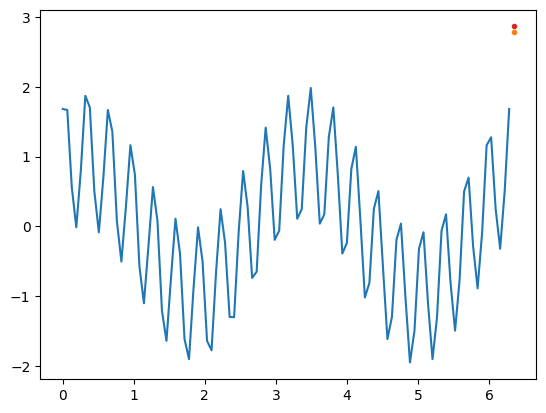

In [503]:

t = np.linspace(0, 2*np.pi, 100)
dt = t[1] - t[0]
# y = np.sin(10*t)
# y = t
# y = np.sqrt(t)
y = np.sin(2*t + 1) + np.sin(20*t + 1)
y = torch.Tensor(y)

plt.plot(t, y)

next_y = tailor_extrapolation(y, dt, 5)
next_t = t[-1] + dt

plt.plot(next_t, next_y, '.', color='tab:orange')

next_y = tailor_extrapolation(y, dt, 1)
next_t = t[-1] + dt

plt.plot(next_t, next_y, '.', color='tab:red')

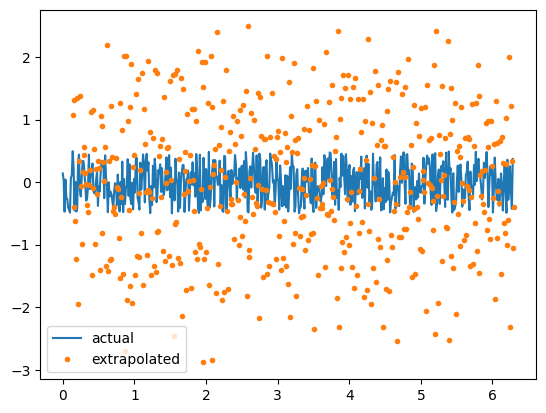

In [219]:
def tailor_extrapolation(y, dt, order=5):
    derivatives = [y.diff(n=i)[-order:] for i in range(order + 1)]
    return sum([
        dy[-1].item()/m.factorial(n)# *dt**n
        for n, dy in enumerate(derivatives)
    ])

t = np.linspace(0, 2*np.pi, 500)
dt = t[1] - t[0]
# y = np.cos(10*t+1)
# y = np.sin(10*t)*t

sig = lambda t, a, b, f, phi=0: np.exp(
        -(t - a)**2 / (2 * b**2)
    ) * np.sin(2*np.pi*f*t + phi)

# sig = lambda t, a, b: (
#     np.exp(
#             np.sin(t/2)
#         ) + np.exp(
#             np.sin(t)
#         )
#     ) * np.exp(
#         -(t - a)**2 / (2 * b**2)
#     )

# y = sig(t, 5, 2, 1)
# y = gaussian_random_walk(len(t))
y = np.random.random(len(t)) - .5

# y = sig(t, 1, .2, 10) +  1/4*sig(t, 3, 1, 1)

y = torch.Tensor(y)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ax1.plot(t, y, '.')
plt.plot(t, y, )
# ax2.plot(t, y, '.')

# for i in range(10, len(y)):
#     next_y = tailor_extrapolation(y[:i], dt, 1)
#     next_t = t[i] + dt
#     ax1.plot(next_t, next_y, '.', color='tab:orange')


for i in range(10, len(y)):
    next_y = tailor_extrapolation(y[:i], dt, 5)
    next_t = t[i] + dt
    plt.plot(next_t, next_y, '.', color='tab:orange')

plt.legend(['actual', 'extrapolated'])


(-inf,
 -15.313467979431152,
 -2.490668535232544,
 0.6867789389417299,
 1.231992483139038)

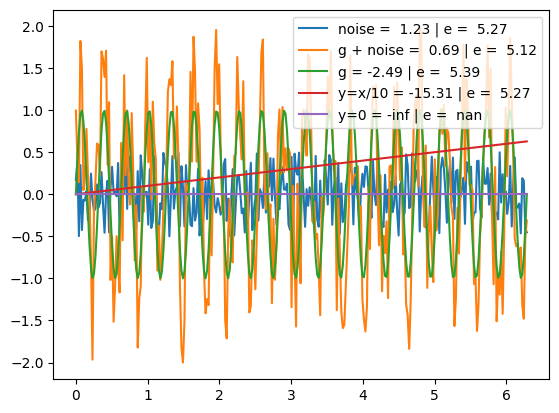

In [194]:
def taylor_mae_loss(y, dt=1, tail=10, n_derivatives=5):
    # y = y/y.sum()
    std = y.std().item()
    std = std if std != 0 else 1
    y = (y - y.mean())/std
    ae = list()
    for i in range(tail, len(y)):
        extrapolated = tailor_extrapolation(y[:i], dt, n_derivatives)
        ae.append(abs(extrapolated - y[i]))

    return torch.log(sum(ae)/len(ae)).item()


def entropy(y):
    y =y**2
    y /= y.sum()
    y[y==0] = 1

    return -((y)*torch.log(y)).sum()

t = np.linspace(0, 2*np.pi, 300)
y = sig(t, 1, .2, 9) +  1/4*sig(t, 3, 1, 1)
y = torch.sin(20*torch.Tensor(t))#*torch.sin(1*torch.Tensor(t))
y_1 = np.zeros(len(y))
y0 = .1*t#sig(t, 1, 1, 1) +  1/4*sig(t, 3, 1, 1)
y1 = y + 2*(np.random.random(len(y)) - .5)
y2 = np.random.random(len(y)) - .5
plt.plot(
    t, y2,
    t, y1,
    t, y,
    t, y0,
    t, y_1
)
y_1 = torch.Tensor(y_1)
y0 = torch.Tensor(y0)
y = torch.Tensor(y)
y1 = torch.Tensor(y1)
y2 = torch.Tensor(y2)
plt.legend([
    f'noise = {taylor_mae_loss(y2) : .2f} | e = {entropy(y2) : .2f}',
    f'g + noise = {taylor_mae_loss(y1) : .2f} | e = {entropy(y1) : .2f}',
    f'g = {taylor_mae_loss(y) : .2f} | e = {entropy(y) : .2f}',
    f'y=x/10 = {taylor_mae_loss(y0) : .2f} | e = {entropy(y0) : .2f}',
    f'y=0 = {taylor_mae_loss(y_1) : .2f} | e = {entropy(y_1) : .2f}'
], loc='upper right')
taylor_mae_loss(y_1),\
    taylor_mae_loss(y0), taylor_mae_loss(y), taylor_mae_loss(y1), taylor_mae_loss(y2)

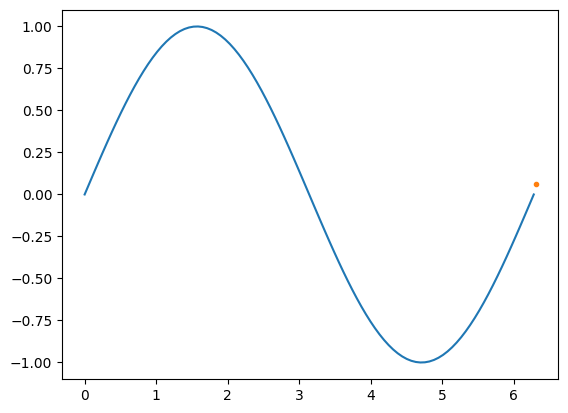

In [216]:
def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk.T[0]

def tailor_extrapolation(y, dt, order=5):
    derivatives = [y.diff(n=i)[-order:] for i in range(order + 1)]
    return sum([
        dy[-1].item()/m.factorial(n) #*dt**n
        for n, dy in enumerate(derivatives)
    ])

t = np.linspace(0, 2*np.pi, 100)
# y = gaussian_random_walk(100)
y = np.sin(t) #+ np.random.random(len(y))
# y = sig(t, 1, .2, 10) #+ np.random.random(len(y)) #+  1/4*sig(t, 3, 1, 1)

# y = np.sin(t)

# y[:100] += np.random.random(100)

y = torch.Tensor(y)

plt.plot(t, y)

d = list()

next_y = tailor_extrapolation(y, dt, 5)
next_t = t[-1] + 2*dt

plt.plot(next_t, next_y, '.', color='tab:orange')

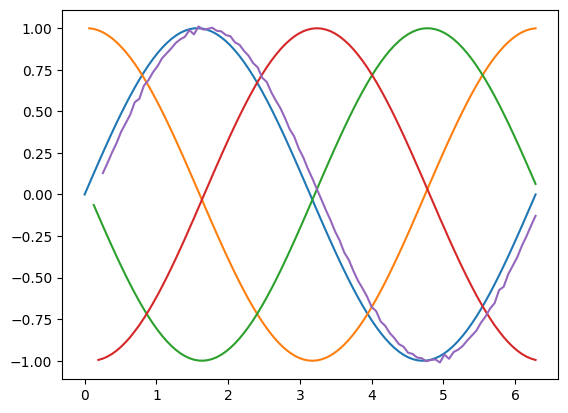

In [221]:
t = np.linspace(0, 2*np.pi, 100)
dt = t[1] - t[0]
y = np.sin(t)
# y = t**2
y = torch.Tensor(y)

# plt.plot(t, y)
# plt.plot(t[:-1], y.diff(n=1)/dt)
# plt.plot(t[:-2], y.diff(n=2)/(dt)**2)
# plt.plot(t[:-3], y.diff(n=3)/(dt)**3)
# plt.plot(t[:-3], y.diff(n=3)/(dt)**3)

for i in range(5):
    plt.plot(t[i:], y.diff(n=i)/(dt**i))
plt.show()

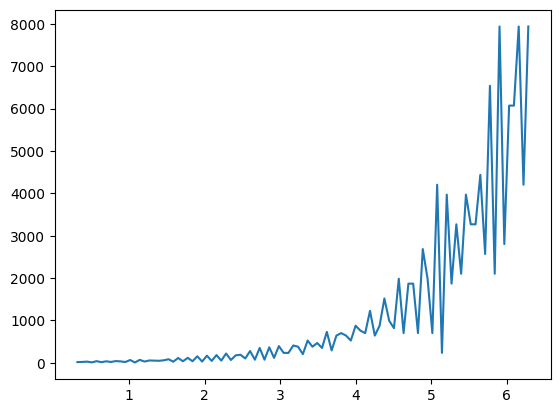

In [216]:
plt.plot(t[5:], (y.diff().diff().diff().diff().diff())/(dt**6))

In [72]:
a = np.random.uniform(-1, 1, (10, 1))
s = np.random.uniform(-1, 1)
e = np.random.uniform(-1, 1)

x = a*s + e

In [107]:
a_ = np.linalg.pinv(a)

In [110]:
a_@a

array([[1.]])

In [85]:
w = np.linalg.pinv(a).T

In [91]:
h = np.random.random((10, 10))
q = np.random.random((10, 10))

(h@q).T

array([[4.19263245, 4.08377809, 3.23610582, 2.97269508, 3.12332701,
        3.82465395, 3.21643709, 2.52590404, 3.4957582 , 3.78776377],
       [4.28694312, 3.97676905, 3.30158652, 2.54556185, 3.26625116,
        3.89656226, 2.93887892, 2.19166298, 3.0880982 , 3.40573245],
       [3.62073032, 3.33863599, 2.9968954 , 2.25356599, 2.81137651,
        3.25254114, 2.10883746, 1.98366244, 2.65029574, 3.24412947],
       [2.91428088, 2.94450435, 2.44169233, 2.41390364, 2.05231572,
        2.74634398, 2.14570567, 1.8733904 , 2.70285732, 2.92117169],
       [3.45668343, 3.57694618, 3.27652162, 2.60526803, 2.39033906,
        2.88427683, 1.97295655, 2.05038358, 3.06944501, 3.37782002],
       [3.48563228, 3.46010966, 2.51558801, 2.85252738, 2.7596988 ,
        3.7410059 , 3.00823495, 2.00837829, 2.96154565, 3.60546979],
       [3.18414504, 3.25562818, 2.41922099, 2.1441322 , 2.1291037 ,
        3.22802427, 2.22090828, 1.63769968, 2.59671696, 2.67620098],
       [2.4705125 , 2.92551699, 2.3205621

In [106]:
q.T@h.T

array([[4.19263245, 4.08377809, 3.23610582, 2.97269508, 3.12332701,
        3.82465395, 3.21643709, 2.52590404, 3.4957582 , 3.78776377],
       [4.28694312, 3.97676905, 3.30158652, 2.54556185, 3.26625116,
        3.89656226, 2.93887892, 2.19166298, 3.0880982 , 3.40573245],
       [3.62073032, 3.33863599, 2.9968954 , 2.25356599, 2.81137651,
        3.25254114, 2.10883746, 1.98366244, 2.65029574, 3.24412947],
       [2.91428088, 2.94450435, 2.44169233, 2.41390364, 2.05231572,
        2.74634398, 2.14570567, 1.8733904 , 2.70285732, 2.92117169],
       [3.45668343, 3.57694618, 3.27652162, 2.60526803, 2.39033906,
        2.88427683, 1.97295655, 2.05038358, 3.06944501, 3.37782002],
       [3.48563228, 3.46010966, 2.51558801, 2.85252738, 2.7596988 ,
        3.7410059 , 3.00823495, 2.00837829, 2.96154565, 3.60546979],
       [3.18414504, 3.25562818, 2.41922099, 2.1441322 , 2.1291037 ,
        3.22802427, 2.22090828, 1.63769968, 2.59671696, 2.67620098],
       [2.4705125 , 2.92551699, 2.3205621

In [86]:
w.T@a

array([[1.]])

In [88]:
w.T@a

array([[1.]])

array([[0.52304299]])

In [78]:
s

0.6455766803940919

In [55]:
y.diff()[0]

tensor(15.7563)

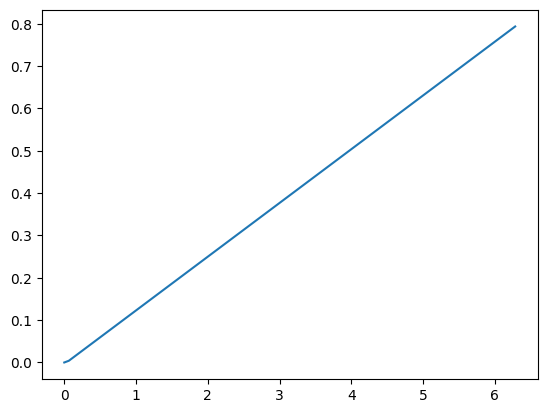

In [40]:
# x = np.arange(1000)
x = np.linspace(0, 2*np.pi, 100)
# y = np.random.random(10)
y = x**2

dy = []
prev = 0
for point in y:
    dy.append(point - prev)
    prev = point

dy = np.array(dy)

# plt.plot(x, y)
plt.plot(x, dy)

In [6]:
# very simple function to plot history of the model training

def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    """
    Generates a Gaussian random walk for a given number of points using numpy.

    Args:
        n: the number of points in the random walk
        stepsize: the standard deviation of the Gaussian distribution used to generate the random steps (default is 1.0)

    Returns:
        A numpy array of shape (n, 2) representing the x and y coordinates of the random walk.
    """
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk.T[0]


def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [112]:
import torch.nn as nn
import torch.nn.init as init
import math
import torch


class AR(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.n_channels = n_channels
        self.w_prev = nn.Parameter(torch.empty(self.n_channels, 1))
        self.reset_parameters()
        self.x_prev = 0

    def reset_parameters(self) -> None:
        init.uniform_(self.w_prev, -0.01, 0.01)

    def forward(self, x):
        out = 0
        Σ_x = torch.stack([sample@sample.T for sample in x])
        term_1 = 2*Σ_x@self.w_prev*x
        term2 = 4*(Σ_x@self.w_prev*x)**2 - 4*(4*Σ_x@x - Σ_x@x_prev)
        print('a', term_1[0, 0])

        return out


X = torch.rand(70, 10, 1)
AR(10)(X)

a tensor([0.0003], grad_fn=<SelectBackward0>)
b tensor([[-0.0026],
        [-0.0010],
        [ 0.0196],
        [ 0.0013],
        [ 0.0009],
        [ 0.0243],
        [ 0.0079],
        [-0.0134],
        [ 0.0125],
        [-0.0009]], grad_fn=<SelectBackward0>) tensor([[1.3779e-04],
        [6.8003e-05],
        [7.5203e-03],
        [2.6985e-05],
        [5.5808e-04],
        [1.2197e-02],
        [5.3288e-03],
        [1.0743e-02],
        [1.1514e-02],
        [4.8956e-04]], grad_fn=<SelectBackward0>)


0

In [128]:
np.sin(10)*np.cos(10) - np.sin(9.999)*np.cos(9.999)

0.00040899473470484837

In [129]:
(np.sin(10) - np.sin(9.999))*np.cos(10) + np.sin(10)*(np.cos(10) - np.cos(9.999))

0.00040853846638676293

In [8]:
# fun = lambda x: x**5
# fun = lambda x: np.sin(2*np.pi/x)
# fun = lambda x: np.sin(10*x)*x
# fun = lambda x: 2.321 + 1.013*(x + 1.212) + 1.232*(x - 1.21321)**2 + 0.123*(x + 3.2112)**3 - 2.3112*x**4
# fun = lambda x: np.tanh(x)
fun = lambda x: np.exp(-x**2)
# fun = lambda x: np.exp(np.sin(x) + np.cos(x))
# fun = lambda x: np.sin(10*x) * np.sin(100*x)# + .8*np.cos(.3*x) + 0.9*np.sin(9*x)
# fun = lambda x: 4/np.pi*(np.sin(x) + 1/3*np.sin(3*x) + 1/5*np.sin(5*x) + 1/7*np.sin(7*x) + 1/9*np.sin(9*x))

In [9]:
n_points = 50

X = sp.stats.zscore(np.array([gaussian_random_walk(n_points) for _  in range(1000)]))
# X = np.array([gaussian_random_walk(n_points) for _  in range(1000)])
# X = (X - X.min(keepdims=True))/(X.max(keepdims=True) - X.min(keepdims=True))
Y = fun(X)

dataset = EpochsDataset(
    (
        X, Y
        # np.expand_dims(X, -1),
        # np.expand_dims(Y, -1)
    ),
    savepath='../datasets/exp',
    # transform=zscore,
    # target_transform=zscore
)
train, test = torch.utils.data.random_split(dataset, [.7, .3])
X, y = next(iter(DataLoader(train, len(train))))

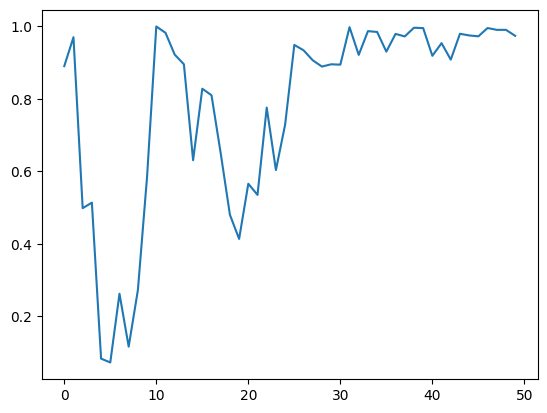

In [7]:
plt.plot(Y[0])

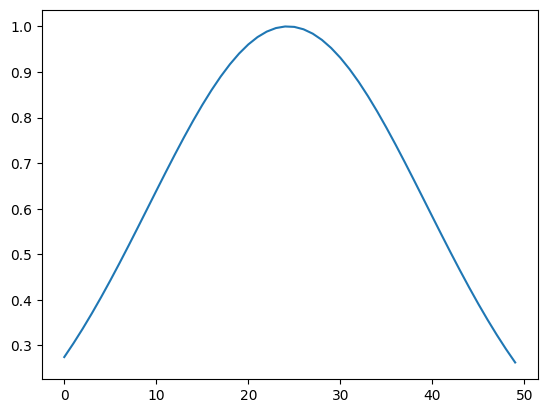

In [8]:
t = np.linspace(X.numpy().min(1).mean(), X.numpy().max(1).mean(), X.shape[1])

plt.plot(fun(t))

In [292]:
y.min(), y.max()

(tensor(-761.6385), tensor(1425.1876))

In [9]:
FourierNet(n_points, 50, 10).state_dict().keys()

odict_keys(['layers.0.a', 'layers.0.b', 'layers.0.a0', 'layers.1.a', 'layers.1.b', 'layers.1.a0', 'layers.2.a', 'layers.2.b', 'layers.2.a0', 'layers.3.a', 'layers.3.b', 'layers.3.a0', 'layers.4.a', 'layers.4.b', 'layers.4.a0', 'layers.5.a', 'layers.5.b', 'layers.5.a0', 'layers.6.a', 'layers.6.b', 'layers.6.a0', 'layers.7.a', 'layers.7.b', 'layers.7.a0', 'layers.8.a', 'layers.8.b', 'layers.8.a0', 'layers.9.a', 'layers.9.b', 'layers.9.a0', 'layer.a', 'layer.b', 'layer.a0', 'bn.weight', 'bn.bias', 'bn.running_mean', 'bn.running_var', 'bn.num_batches_tracked'])

In [10]:
FourierNet(n_points, 10, 10)(X)

tensor([[-2.1541e-02, -2.0907e-02,  1.0106e-02,  ..., -1.6499e-02,
         -1.9460e-02, -1.8719e-02],
        [-1.0084e-02, -9.1376e-03, -9.5230e-03,  ..., -9.2760e-03,
         -7.6649e-03, -6.7425e-03],
        [ 8.2644e-03,  1.7102e-03, -4.2055e-03,  ..., -1.7405e-03,
         -1.0098e-03, -1.6720e-03],
        ...,
        [-1.4017e-02, -1.7056e-02, -2.9515e-02,  ...,  7.5595e-03,
          6.1516e-04, -5.5659e-03],
        [ 2.3020e-02, -4.7428e-02,  2.6967e-02,  ..., -1.7083e-02,
         -1.4615e-02, -1.6117e-02],
        [-7.4118e-02,  3.8606e-02, -8.4335e-05,  ..., -9.0870e-02,
         -9.0392e-02, -8.7674e-02]], grad_fn=<AddBackward0>)

In [22]:
model = FourierNet(n_points, n_points, 50)

optimizer = torch.optim.Adam
loss = torch.nn.MSELoss()
loss = nn.L1Loss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = ('mse', nn.L1Loss())

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            ['layer.a0', 'layer.a', 'layer.b'],
            0.001
        )
    ]
)

In [44]:
model.trainer.epoch_number = 0

Epoch 0:  loss_train:  0.6746   |    mse_train:  0.6740   |    loss_val:  0.5535   |    mse_val:  0.5529
Epoch 1:  loss_train:  0.5639   |    mse_train:  0.5633   |    loss_val:  0.5459   |    mse_val:  0.5452
Epoch 2:  loss_train:  0.5195   |    mse_train:  0.5189   |    loss_val:  0.5348   |    mse_val:  0.5342
Epoch 3:  loss_train:  0.5005   |    mse_train:  0.4999   |    loss_val:  0.4950   |    mse_val:  0.4944
Epoch 4:  loss_train:  0.4773   |    mse_train:  0.4766   |    loss_val:  0.4724   |    mse_val:  0.4718
Epoch 5:  loss_train:  0.4754   |    mse_train:  0.4747   |    loss_val:  0.4745   |    mse_val:  0.4738
Epoch 6:  loss_train:  0.4548   |    mse_train:  0.4542   |    loss_val:  0.4644   |    mse_val:  0.4638
Epoch 7:  loss_train:  0.4453   |    mse_train:  0.4447   |    loss_val:  0.4609   |    mse_val:  0.4602
Epoch 8:  loss_train:  0.4229   |    mse_train:  0.4223   |    loss_val:  0.4451   |    mse_val:  0.4444
Epoch 9:  loss_train:  0.4248   |    mse_train:  0.4242

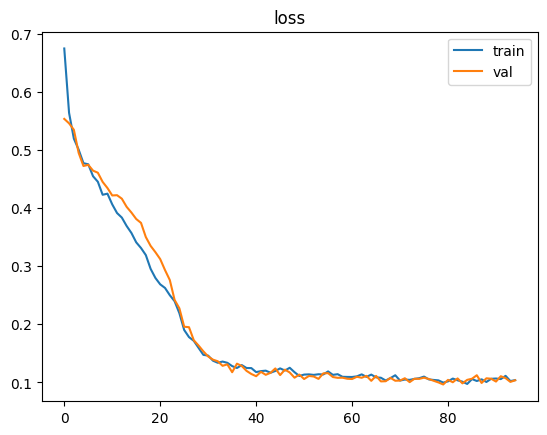

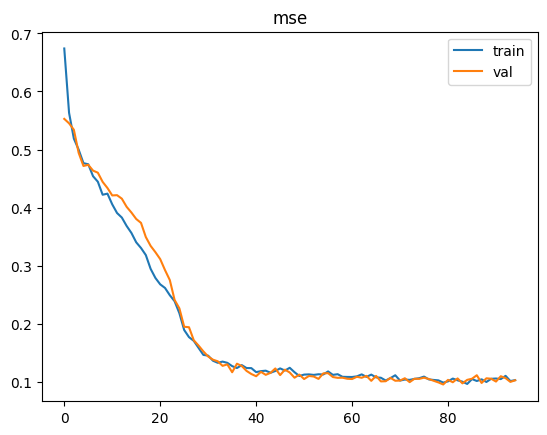

In [23]:
history = model.fit(train, n_epochs=500, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [24]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.09298953041434288
train_mse: 0.09223588928580284
loss: 0.10376117005944252
mse: 0.10300752893090248


In [14]:
X, y = next(iter(DataLoader(test, len(test))))
y_pred = model(X)
y_pred = y_pred.detach().numpy()

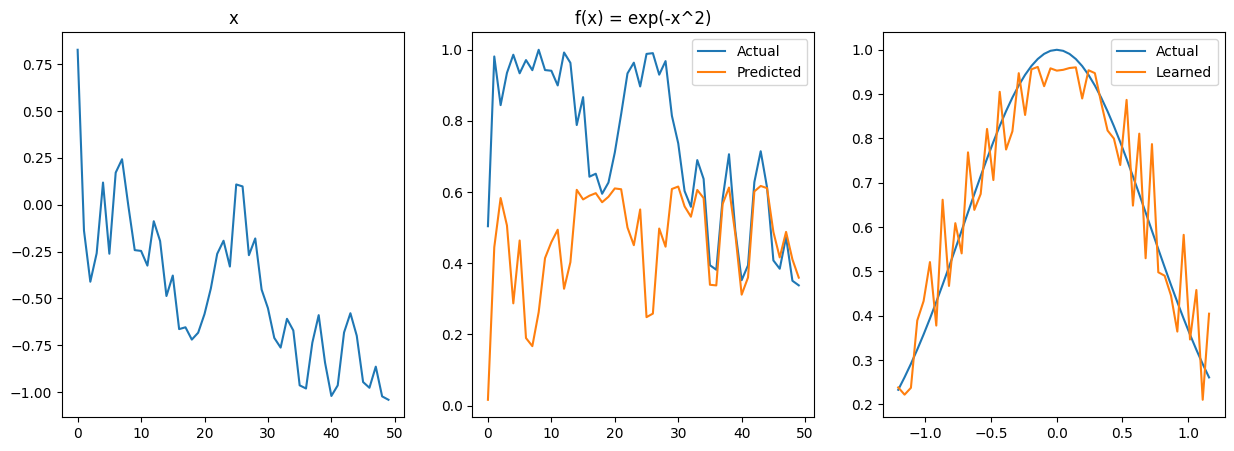

In [29]:
i = np.random.randint(0, y_pred.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(X[i])
ax1.set_title('x')
ax2.plot(y[i])
ax2.set_title('f(x) = exp(-x^2)')
ax2.plot(y_pred[i])
ax2.legend(['Actual', 'Predicted'], loc='upper right')

t = np.linspace(X.numpy().min(1).mean(), X.numpy().max(1).mean(), X.shape[1])
ax3.plot(t, fun(t))
ax3.plot(t, model(torch.Tensor(np.expand_dims(t, 0))).detach()[0])
ax3.legend(['Actual', 'Learned'], loc='upper right')

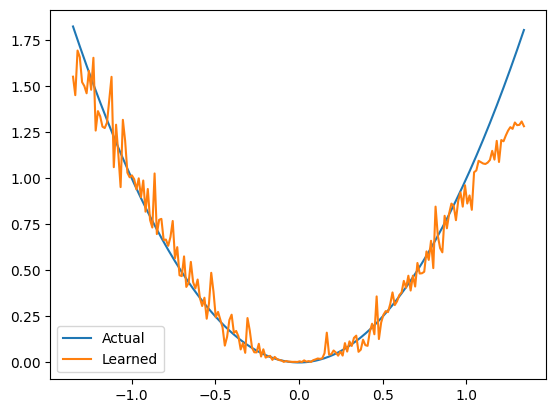

In [397]:
model = PowerNet(n_points, 5)

optimizer = torch.optim.Adam
loss = torch.nn.MSELoss()
# loss = nn.L1Loss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = ('mse', nn.L1Loss())

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        # L2Reg(
        #     ['layer.a0', 'layer.a', 'layer.b'],
        #     0.01
        # )
    ]
)

In [17]:
import numpy as np

x = 2*np.random.random(10) - 1
e = 2*np.random.random(10) - 1

In [48]:
A = np.array([
    x,
    x + e,
    x + 2*e,
    x + 8*e,
    x + 512*e
])

B = np.array([
    x + 512*e,
    x + 8*e,
    x + 2*e,
    x + e,
    x
])

In [46]:
np.cov(x,
    x + e)

array([[0.28823851, 0.41396102],
       [0.41396102, 0.81918753]])

In [53]:
np.corrcoef(A, B)

array([[1.        , 0.8519062 , 0.72751803, 0.53643521, 0.44453026,
        0.44453026, 0.53643521, 0.72751803, 0.8519062 , 1.        ],
       [0.8519062 , 1.        , 0.97907786, 0.89895992, 0.84780459,
        0.84780459, 0.89895992, 0.97907786, 1.        , 0.8519062 ],
       [0.72751803, 0.97907786, 1.        , 0.9692849 , 0.9379771 ,
        0.9379771 , 0.9692849 , 1.        , 0.97907786, 0.72751803],
       [0.53643521, 0.89895992, 0.9692849 , 1.        , 0.99443396,
        0.99443396, 1.        , 0.9692849 , 0.89895992, 0.53643521],
       [0.44453026, 0.84780459, 0.9379771 , 0.99443396, 1.        ,
        1.        , 0.99443396, 0.9379771 , 0.84780459, 0.44453026],
       [0.44453026, 0.84780459, 0.9379771 , 0.99443396, 1.        ,
        1.        , 0.99443396, 0.9379771 , 0.84780459, 0.44453026],
       [0.53643521, 0.89895992, 0.9692849 , 1.        , 0.99443396,
        0.99443396, 1.        , 0.9692849 , 0.89895992, 0.53643521],
       [0.72751803, 0.97907786, 1.       

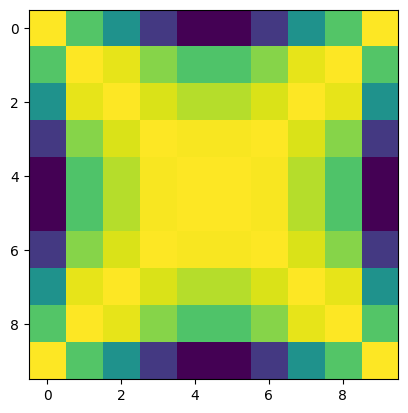

In [54]:
import matplotlib.pyplot as plt

plt.imshow(np.corrcoef(A, B))

In [398]:
model.trainer.epoch_number = 0

Epoch 0:  loss_train:  131.6999   |    mse_train:  1.3754   |    loss_val:  10.7023   |    mse_val:  0.6814
Epoch 1:  loss_train:  48.3450   |    mse_train:  0.9420   |    loss_val:  4.5339   |    mse_val:  0.5884
Epoch 2:  loss_train:  16.2655   |    mse_train:  0.7452   |    loss_val:  2.7147   |    mse_val:  0.5535
Epoch 3:  loss_train:  8.1835   |    mse_train:  0.7023   |    loss_val:  2.3150   |    mse_val:  0.5412
Epoch 4:  loss_train:  8.8546   |    mse_train:  0.7151   |    loss_val:  2.0662   |    mse_val:  0.5324
Epoch 5:  loss_train:  9.7401   |    mse_train:  0.6951   |    loss_val:  1.7112   |    mse_val:  0.5181
Epoch 6:  loss_train:  8.9824   |    mse_train:  0.6596   |    loss_val:  1.3640   |    mse_val:  0.5025
Epoch 7:  loss_train:  7.0083   |    mse_train:  0.6180   |    loss_val:  1.1174   |    mse_val:  0.4856
Epoch 8:  loss_train:  4.6384   |    mse_train:  0.5738   |    loss_val:  0.9428   |    mse_val:  0.4714
Epoch 9:  loss_train:  2.8322   |    mse_train:  0

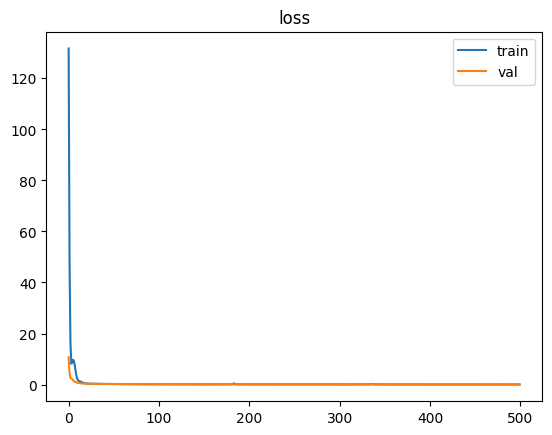

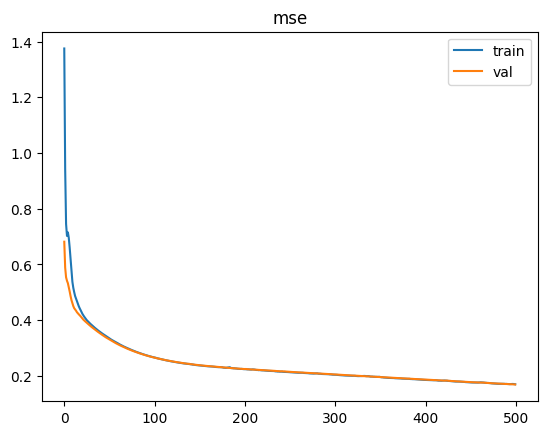

In [399]:
history = model.fit(train, n_epochs=500, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [400]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.0592590220272541
train_mse: 0.1709793508052826
loss: 0.22648873329162597
mse: 0.17995688915252686


In [401]:
X, y = next(iter(DataLoader(test, len(test))))
y_pred = model(X)
y_pred = y_pred.detach().numpy()

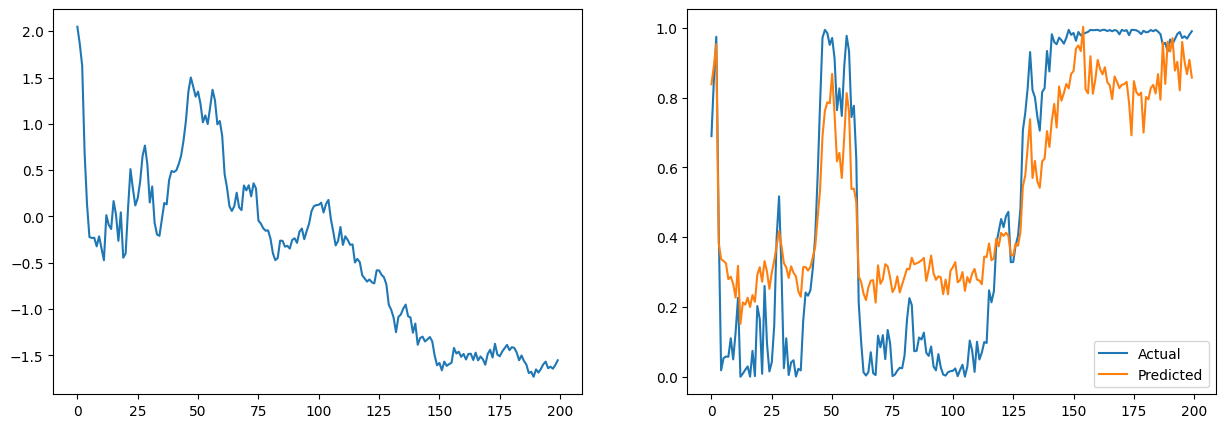

In [408]:
i = np.random.randint(0, y_pred.shape[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(X[i])
ax2.plot(y[i])
ax2.plot(y_pred[i])
plt.legend(['Actual', 'Predicted'])

In [409]:
t = np.linspace(X.numpy().min(1).mean(), X.numpy().max(1).mean(), X.shape[1])

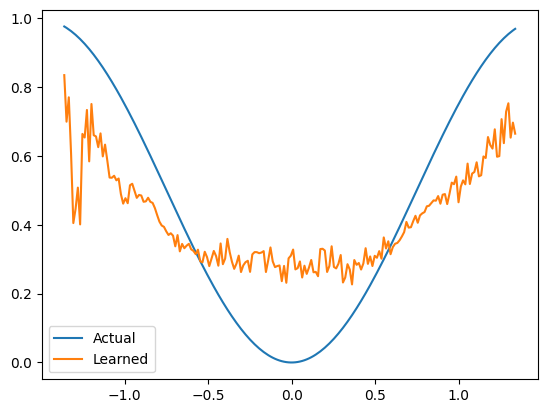

In [410]:
plt.plot(t, fun(t))
plt.plot(t, model(torch.Tensor(np.expand_dims(t, 0))).detach()[0])
plt.legend(['Actual', 'Learned'])

In [8]:
n_points = 200

# X = sp.stats.zscore(np.array([gaussian_random_walk(n_points) for _  in range(1000)]))
X = np.expand_dims(gaussian_random_walk(1000), 1)
Y = fun(X)

dataset = EpochsDataset(
    (
        X, Y
        # np.expand_dims(X, -1),
        # np.expand_dims(Y, -1)
    ),
    savepath='../datasets/exp',
    # transform=zscore,
    # target_transform=zscore
)
train, test = torch.utils.data.random_split(dataset, [.7, .3])
X, y = next(iter(DataLoader(train, len(train))))

In [5]:
import math

class Taylor(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.n_points = n_points
        self.n_components = n_components
        self.d = nn.Parameter(torch.empty(1, self.n_components, 1))
        self.x0 = nn.Parameter(torch.empty(1))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.uniform_(self.d, -0.01, 0.01)
        init.uniform_(self.x0, -0.01, 0.01)

    def forward(self, x):
        a = x*self.x0

        out = 0
        for n in range(self.n_components):
            out += ( (x - a)**n )*( ( x*self.d[:, n] ) / math.factorial(n) )

        return out.sum(1, keepdim=True)

In [6]:
class TaylorNet(BaseModel):

    def __init__(self, n_components):
        super().__init__()
        self.layer = Taylor(n_components)

    def forward(self, x):
        x = self.layer(x)
        return x

In [102]:
X.shape

torch.Size([700, 1])

In [103]:
y.min(), y.max()

(tensor(-8920639.), tensor(11.6138))

In [109]:
TaylorNet(5)(X).shape

torch.Size([700, 1])

In [9]:
model = TaylorNet(10)

optimizer = torch.optim.Adam
loss = torch.nn.MSELoss()
# loss = nn.L1Loss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = ('mse', nn.L1Loss())

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        # L2Reg(
        #     ['layer.a0', 'layer.a', 'layer.b'],
        #     0.01
        # )
    ]
)

Epoch 0:  loss_train:  52865307989.3333   |    mse_train:  153476.9115   |    loss_val:  49277046784.0000   |    mse_val:  158743.0859
Epoch 1:  loss_train:  50417179306.6667   |    mse_train:  152280.6979   |    loss_val:  49218487637.3333   |    mse_val:  157597.7734
Epoch 2:  loss_train:  48589187754.6667   |    mse_train:  151680.6615   |    loss_val:  51312032426.6667   |    mse_val:  159639.9688
Epoch 3:  loss_train:  48700512938.6667   |    mse_train:  153608.7188   |    loss_val:  52895965184.0000   |    mse_val:  162350.4948
Epoch 4:  loss_train:  48808259584.0000   |    mse_train:  154294.8281   |    loss_val:  52034603690.6667   |    mse_val:  161104.2083
Epoch 5:  loss_train:  47940364970.6667   |    mse_train:  152836.2448   |    loss_val:  49901984426.6667   |    mse_val:  157459.9531
Epoch 6:  loss_train:  47082962944.0000   |    mse_train:  150801.6875   |    loss_val:  48317913770.6667   |    mse_val:  155849.9974
Epoch 7:  loss_train:  46900116138.6667   |    mse_trai

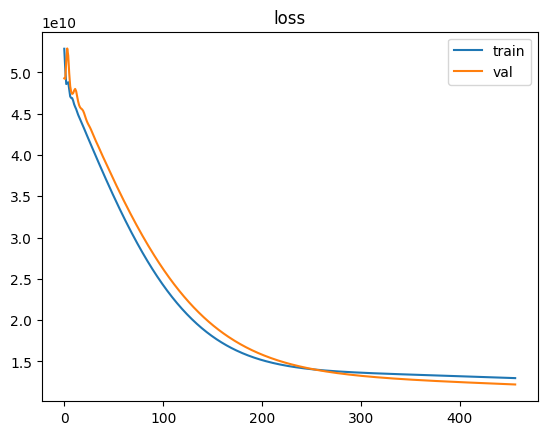

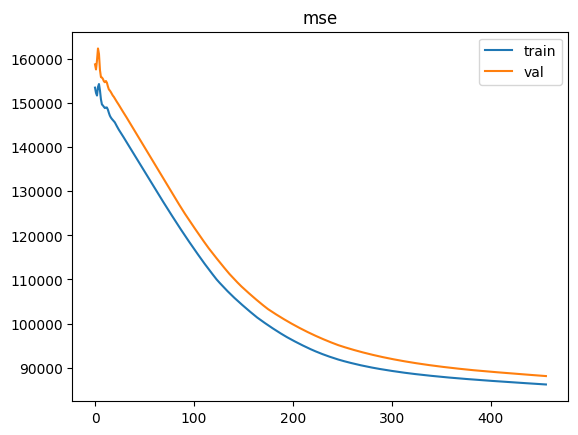

In [12]:
history = model.fit(train, n_epochs=500, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [13]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 12856250675.2
train_mse: 86519.76484375
loss: 10224278374.4
mse: 78597.994140625
